# Calculate Difference between SnowModel and SWE Reanalysis

In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import contextily as ctx

import datetime as dt
from datetime import datetime

import pickle
import scipy.stats as stats
# SVD function from scipy
from scipy.linalg import svd

import rioxarray as rxr
import xarray as xr
import rasterio as rio
import matplotlib

In [2]:
wstates = gpd.read_file('../data/misc/western_states.shp')
wstates_4326=wstates.to_crs('epsg:4326')
cluster_polys = gpd.read_file('../data/cluster_polygons.geojson')
wus_boundary = gpd.read_file('../data/misc/western_boundary.geojson')

In [3]:
sm = xr.open_dataset('../data/snowmodel/sm_clip_swed_2017_04_01.nc').rio.write_crs('epsg:4326',inplace=True)

In [4]:
base_dir = '../data/reanalysis/swe/'
year = 2017
yr_dir = f'{base_dir}{year}/SWE_Post/'
fname = f'{base_dir}{year}/SWE_Post/{os.listdir(yr_dir)[0]}'
#fname_lst.append(f'{base_dir}{year}/SWE_Post/{fname}')
## load netcdf ##
def preprocess(ds):
    ds['SWE_Post'] = ds['SWE_Post'].T
    ## set spatial reference ##
    ds.rio.write_crs('EPSG:4326',inplace = True)
    ds = ds.rename({'Latitude':'y','Longitude':'x'})
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)
    return ds
    # ds.expand_dims(dim = 'Year')
    
## load files and concatenate by Year ##
ds = xr.open_mfdataset(fname, concat_dim = 'Year',combine = 'nested', preprocess = preprocess)
## rename years ##
#ds['Year'] = 2017
ds.rio.write_crs('epsg:4326')
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 1)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
Dimensions without coordinates: Year
Data variables:
    SWE_Post     (Year, y, x) float32 dask.array<chunksize=(1, 4050, 5175), meta=np.ndarray>

In [2]:
test = xr.open_dataset('../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc')

In [3]:
test

<xarray.Dataset>
Dimensions:    (Latitude: 4050, Longitude: 5175)
Coordinates:
  * Latitude   (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
Data variables:
    SWE_Post   (Longitude, Latitude) float32 ...

In [3]:
sm

<xarray.Dataset>
Dimensions:      (y: 15316, x: 19572, date: 1)
Coordinates:
  * y            (y) float64 49.0 49.0 49.0 48.99 ... 31.01 31.01 31.0 31.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
  * date         (date) datetime64[ns] 2017-04-01
Data variables:
    spatial_ref  int64 ...
    swed         (date, y, x) float32 ...

In [ ]:
sm.swed.plot()

In [5]:
sm.rio.crs

CRS.from_epsg(4326)

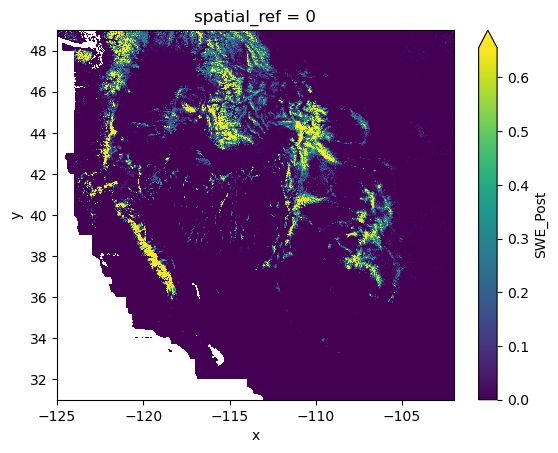

In [10]:
ds.SWE_Post.plot(cmap = 'Blues',robust=True)

In [ ]:
sm_coarser = sm.coarsen(x=8, boundary='trim').mean().coarsen(y=8, boundary='trim').mean()
sm_coarser.swed.plot()

In [5]:
sm_repr_match = sm.rio.reproject_match(ds, resampling=rio.enums.Resampling.cubic)

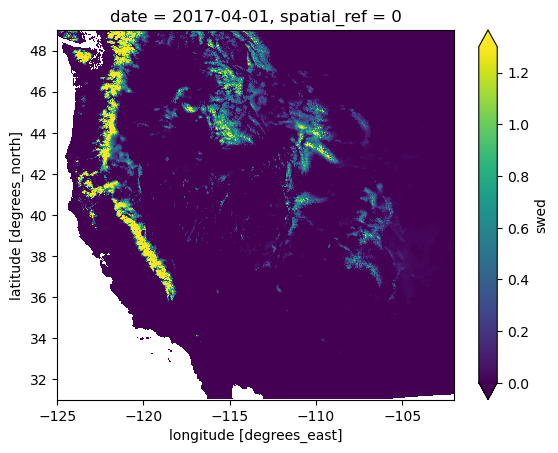

In [25]:
sm_repr_match.swed.plot(vmin=0, vmax=1.3)

In [6]:
difference = sm_repr_match.swed - ds.SWE_Post

In [20]:
difference

<xarray.DataArray (date: 1, y: 4050, x: 5175, Year: 1)>
dask.array<subtract, shape=(1, 4050, 5175, 1), dtype=float32, chunksize=(1, 4050, 5175, 1), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * date         (date) datetime64[ns] 2017-04-01
    spatial_ref  int64 0
Dimensions without coordinates: Year

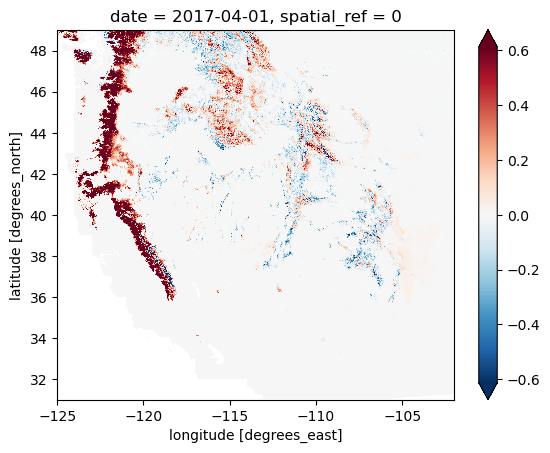

In [22]:
difference.plot(robust=True)

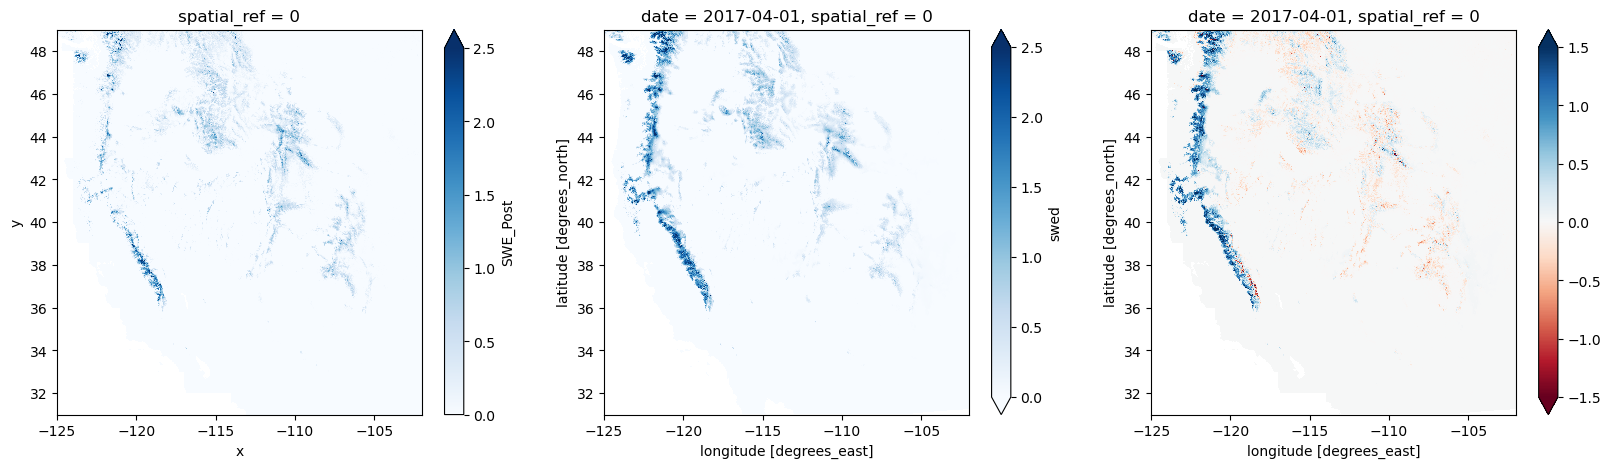

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ds.SWE_Post.plot(cmap = 'Blues', ax=ax[0], vmin=0, vmax=2.5)
sm_repr_match.swed.plot(cmap = 'Blues', ax=ax[1], vmin=0, vmax=2.5)
difference.plot(cmap = 'RdBu', ax=ax[2], vmin=-1.5, vmax=1.5)

(35.0, 46.0)

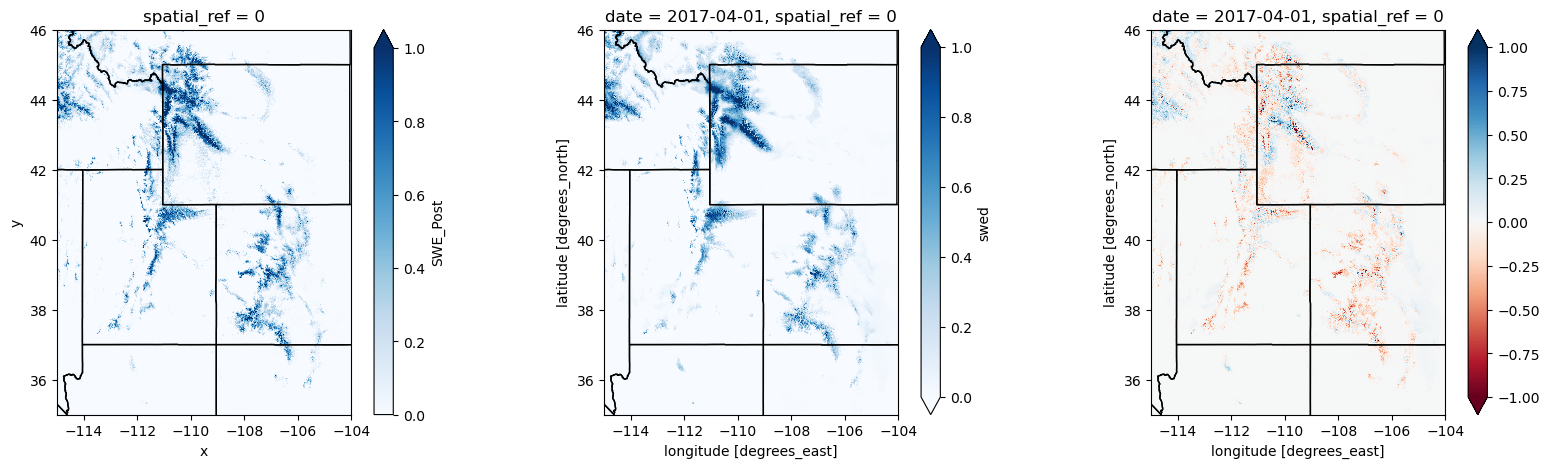

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ds.SWE_Post.plot(cmap='Blues', ax=ax[0], vmin=0, vmax=1)
wstates_4326.plot(ax=ax[0], facecolor='none',edgecolor='k')
ax[0].set_xlim(-115,-104)
ax[0].set_ylim(35,46)

sm_repr_match.swed.plot(cmap='Blues', ax=ax[1], vmin=0, vmax=1)
wstates_4326.plot(ax=ax[1], facecolor='none',edgecolor='k')
ax[1].set_xlim(-115,-104)
ax[1].set_ylim(35,46)

difference.plot(cmap='RdBu', ax=ax[2], vmin=-1, vmax=1)
wstates_4326.plot(ax=ax[2], facecolor='none',edgecolor='k')
ax[2].set_xlim(-115,-104)
ax[2].set_ylim(35,46)

In [7]:
#sm_repr_match_coarser = sm_repr_match.coarsen(x=8, boundary='trim').mean().coarsen(y=8, boundary='trim').mean()
difference_coarser = difference.coarsen(x=8, boundary='trim').mean().coarsen(y=8, boundary='trim').mean()
#sm_coarser.swed.plot()

In [42]:
from matplotlib.colors import LinearSegmentedColormap
colors1=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'] #,'#ffff33'
cmap1 = LinearSegmentedColormap.from_list('clusters', colors1)

colors2=['#969696','#636363','#f7f7f7','#cccccc','#252525'] #,'#ffff33'
cmap2 = LinearSegmentedColormap.from_list('clusters', colors2)


(35.0, 43.0)

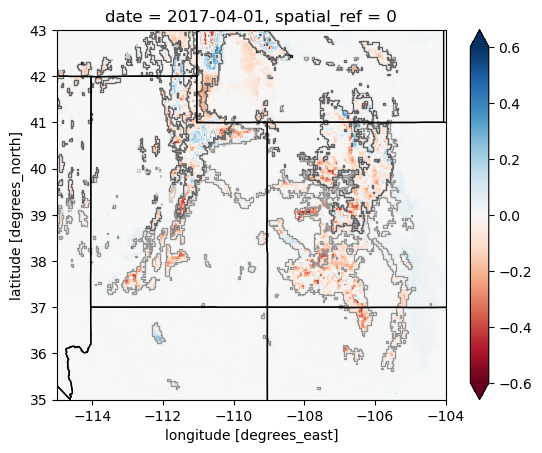

In [43]:
fig, ax = plt.subplots()

difference_coarser.plot(cmap='RdBu', ax=ax, vmin=-0.6, vmax=0.6) #, alpha=0.5
cluster_polys.plot(column='cluster', ax=ax, facecolor='none', linewidth=1, cmap=plt.colormaps.get_cmap(cmap2)) #
wstates_4326.plot(ax=ax, facecolor='none',edgecolor='k')

ax.set_xlim(-115,-104)
ax.set_ylim(35,43)

<Axes: >

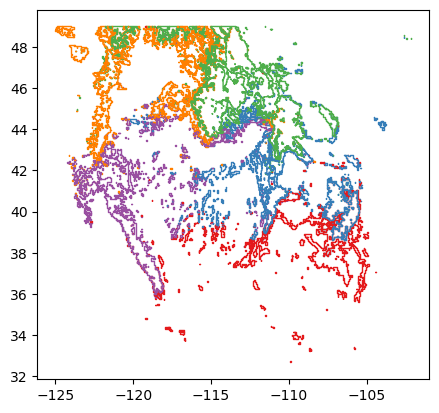

In [51]:
cluster_polys.plot(column='cluster', facecolor='none', cmap = plt.colormaps.get_cmap(cmap1))

### Download HUC10 Watershed Boundaries:

In [29]:
from pygeohydro import WBD
import pygeohydro

In [23]:
tuolumne = wbd.byids("huc8", ["18040009"])

<Axes: >

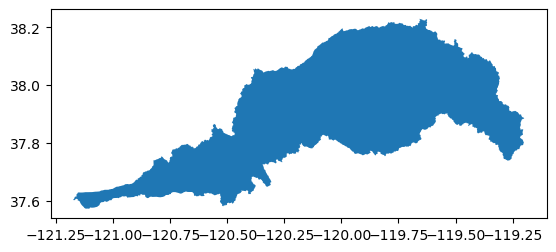

In [25]:
tuolumne.plot()

In [32]:
# Download all HUC10 boundaries in the US:
huc10 = pygeohydro.huc_wb_full(10)

In [42]:
huc10_wus = huc10.overlay(wus_boundary.to_crs('epsg:4269'), how='intersection')

In [44]:
huc10_wus.to_file('../data/huc10.geojson', driver='GeoJSON')

### Plot Watershed boundaries for select regions:

<Axes: >

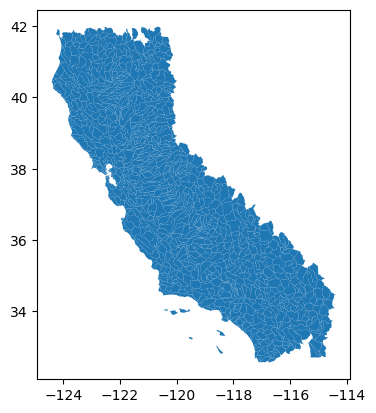

In [56]:
huc10_wus[huc10_wus['states']=='CA'].plot()

<Axes: >

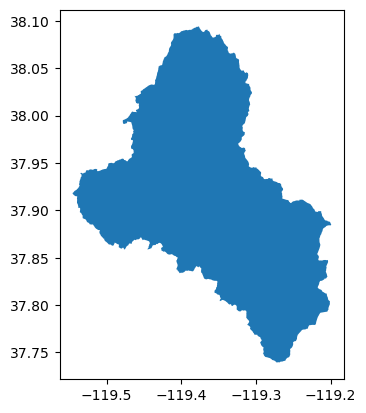

In [69]:
huc10_wus[huc10_wus['name']=='Headwaters Tuolumne River'].plot()

<Axes: >

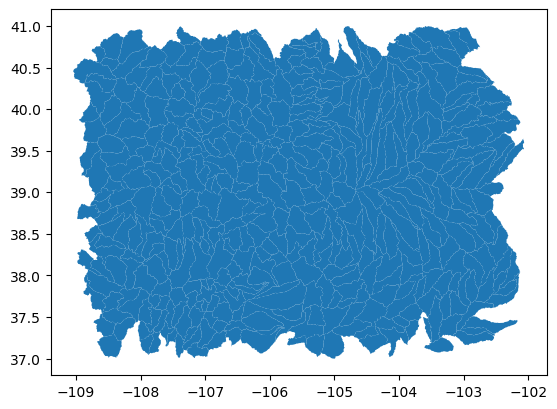

In [71]:
huc10_wus[huc10_wus['states']=='CO'].plot()

<Axes: >

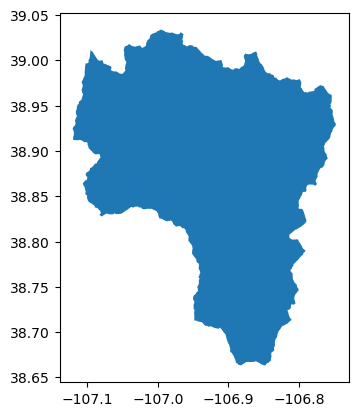

In [79]:
huc10_wus.loc[(huc10_wus['states']=='CO') & (huc10_wus['name'].str.contains('East River'))].plot()

In [31]:
#huc8 = pygeohydro.huc_wb_full(8)

,huc2,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,states,huc8,name,shape_Leng,shape_Area,ObjectID,geometry
0,01,{6F81FAE5-7EC8-47A5-95A2-9C803269ECF6},{B15115CF-0A97-435C-B715-EDDD35BA0BF1},USGS one meter x68y471 MA ME MA QL1 UTM18 L1 2015,U.S. Geological Survey,NaN,2023-05-16,NaN,4.246290e+05,1718.410000,"MA,VT",01080203,Deerfield River,NaN,NaN,1,"POLYGON ((-72.96429 43.09297, -72.96425 43.092..."
1,01,{D4E96931-8FD5-4C44-AF23-C2A3C558A773},NaN,NaN,NaN,NaN,2019-07-31,NaN,1.028265e+06,4161.240000,"CN,ME",01010009,Little River-Saint John River,NaN,NaN,2,"POLYGON ((-68.31284 47.89584, -68.31279 47.895..."
2,01,{AAB3BA4E-77CF-4233-B100-94B3DBE345AE},NaN,NaN,NaN,NaN,2019-07-31,NaN,8.978838e+05,3633.610000,"CN,ME",01010011,Keswick River-Saint John River,NaN,NaN,3,"POLYGON ((-67.11461 46.30400, -67.11305 46.303..."
3,01,{17CF1648-B6CE-498E-A826-EC6CB47FB1C9},NaN,NaN,NaN,NaN,2019-07-31,NaN,1.561973e+06,6321.090000,"CN,ME",01010004,Aroostook River,NaN,NaN,4,"POLYGON ((-68.19360 47.16369, -68.19342 47.163..."
4,01,{530F8058-881E-45F5-9F80-D7027E49B810},NaN,NaN,NaN,NaN,2019-07-31,NaN,3.281535e+05,1327.990000,"CN,ME",01010005,Meduxnekeag River,NaN,NaN,5,"POLYGON ((-67.98416 46.45343, -67.98335 46.452..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,22,{D41FF025-0384-46A9-AD2A-70C3BE1E124D},{F1316F58-0610-4793-8A92-7EB6C00FE488},NaN,NaN,NaN,2016-09-22,NaN,1.451357e+05,587.343227,MP,22020101,Saipan Island,NaN,NaN,23,"POLYGON ((145.81088 15.34102, 145.81129 15.341..."
2409,22,{C29C4386-1288-40D4-9652-FDD0E1289675},{F1316F58-0610-4793-8A92-7EB6C00FE488},NaN,NaN,NaN,NaN,NaN,1.114234e+05,450.914506,MP,22020104,Rota Island,NaN,NaN,24,"POLYGON ((145.28509 14.24641, 145.28595 14.246..."
2410,22,{ED0968A7-576B-449A-9962-B8FDB7B4C512},{F1316F58-0610-4793-8A92-7EB6C00FE488},NaN,NaN,NaN,NaN,NaN,3.274230e+04,132.503380,MP,22020210,Farallon de Medinilla,NaN,NaN,25,"POLYGON ((146.05285 15.95489, 146.05194 15.954..."
2411,22,{72511286-2E52-41FB-8E31-C301FA145C7C},{F1316F58-0610-4793-8A92-7EB6C00FE488},NaN,NaN,NaN,NaN,NaN,6.726095e+04,272.195401,MP,22020209,Anatahan Island,NaN,NaN,26,"POLYGON ((145.66104 16.42103, 145.66194 16.420..."
